In [1]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from shapely.geometry import box
np.set_printoptions(suppress=True)

Image taken from Google and bounding boxes annoted using VIA by VGG: https://www.robots.ox.ac.uk/~vgg/software/via/

In [2]:
# config
IMG_PATH = 'nms_data/sample.jpg'
LABELS_PATH = 'nms_data/labels.json'
IOU_THRESHOLD = 0.5 # threshold for suppression

In [3]:
def get_image(img_path):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

In [4]:
def get_bboxes(labels_path):
    with open(labels_path) as f:
        data = json.load(f)

    df = pd.DataFrame(columns=['minx','miny','maxx','maxy']).astype('int')

    for i, region in enumerate(data['sample.jpg200924']['regions']):
        df.loc[i,'minx'] = region['shape_attributes']['x']
        df.loc[i,'miny'] = region['shape_attributes']['y']
        df.loc[i,'maxx'] = region['shape_attributes']['x'] + region['shape_attributes']['width']
        df.loc[i,'maxy'] = region['shape_attributes']['y'] + region['shape_attributes']['height']
    return df

In [5]:
def plot_bboxes(img, bboxes):
    for bbox in bboxes:
        cv2.rectangle(img, (int(bbox[0]), int(bbox[1])), (int(bbox[2]), int(bbox[3])), (255, 0, 0), 2)
    plt.imshow(img)
    plt.show() 

    minx  miny   maxx    maxy
0  418.0  35.0  907.0  1056.0
1  389.0  16.0  883.0  1121.0


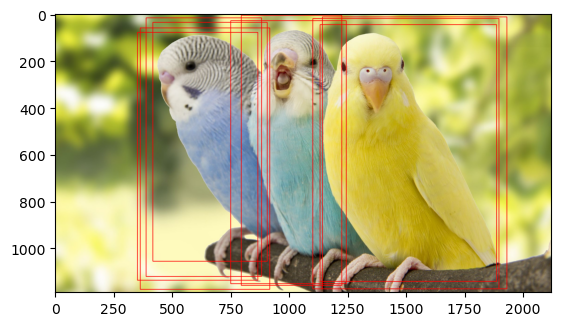

In [6]:
img = get_image(IMG_PATH)
df = get_bboxes(LABELS_PATH)
print(df.head(2))

bboxes = df.values
plot_bboxes(img, bboxes)

In [7]:
# generate confidences
confs = np.random.uniform(0.8,1,len(bboxes))

In [8]:
def get_box(bbox):
    minx, miny, maxx, maxy = bbox[0], bbox[1], bbox[2], bbox[3]
    return box(minx, miny, maxx, maxy)

def get_iou(bbox1, bbox2):
    p1 = get_box(bbox1)
    p2 = get_box(bbox2)
    iou = p1.intersection(p2).area / p1.union(p2).area
    return iou

def run_nms(bboxes, confs, iou_threshold):

    # sorting by confidence
    bboxes = bboxes[confs.argsort()[::-1]]

    keep = []
    while len(bboxes):
        # bounding box with highest confidence
        bbox1 = bboxes[0]

        # keep bbox with highest confidence
        keep.append(bboxes[0])

        delete_idxs = [0]
        for idx in range(1, len(bboxes)):
            bbox2 = bboxes[idx]
            iou = get_iou(bbox1, bbox2)
            if iou > iou_threshold:
                delete_idxs.append(idx)
        
        # suppressing bboxes
        bboxes = np.delete(bboxes, delete_idxs, axis=0)
    keep = np.array(keep)
    return keep

In [9]:
keep = run_nms(bboxes, confs, IOU_THRESHOLD)
keep

array([[ 418.,   35.,  907., 1056.],
       [1143.,   12., 1932., 1174.],
       [ 751.,   28., 1245., 1152.]])

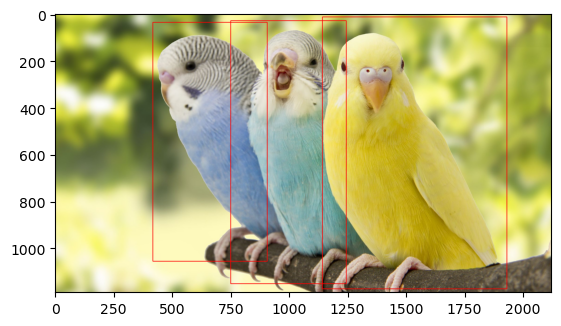

In [10]:
img = get_image(IMG_PATH)
plot_bboxes(img, keep)